In [1]:
import pickle

In [24]:
#load bid_df
with open('/content/bid_df.pickle', 'rb') as f:
    bid_df = pickle.load(f)

# LSTM

Epoch 1/200
18/18 - 3s - loss: 0.0321 - 3s/epoch - 165ms/step
Epoch 2/200
18/18 - 0s - loss: 0.0086 - 85ms/epoch - 5ms/step
Epoch 3/200
18/18 - 0s - loss: 0.0044 - 86ms/epoch - 5ms/step
Epoch 4/200
18/18 - 0s - loss: 0.0042 - 85ms/epoch - 5ms/step
Epoch 5/200
18/18 - 0s - loss: 0.0042 - 84ms/epoch - 5ms/step
Epoch 6/200
18/18 - 0s - loss: 0.0041 - 87ms/epoch - 5ms/step
Epoch 7/200
18/18 - 0s - loss: 0.0040 - 85ms/epoch - 5ms/step
Epoch 8/200
18/18 - 0s - loss: 0.0039 - 87ms/epoch - 5ms/step
Epoch 9/200
18/18 - 0s - loss: 0.0040 - 97ms/epoch - 5ms/step
Epoch 10/200
18/18 - 0s - loss: 0.0041 - 86ms/epoch - 5ms/step
Epoch 11/200
18/18 - 0s - loss: 0.0043 - 85ms/epoch - 5ms/step
Epoch 12/200
18/18 - 0s - loss: 0.0038 - 93ms/epoch - 5ms/step
Epoch 13/200
18/18 - 0s - loss: 0.0039 - 84ms/epoch - 5ms/step
Epoch 14/200
18/18 - 0s - loss: 0.0038 - 96ms/epoch - 5ms/step
Epoch 15/200
18/18 - 0s - loss: 0.0036 - 85ms/epoch - 5ms/step
Epoch 16/200
18/18 - 0s - loss: 0.0044 - 88ms/epoch - 5ms/step
E

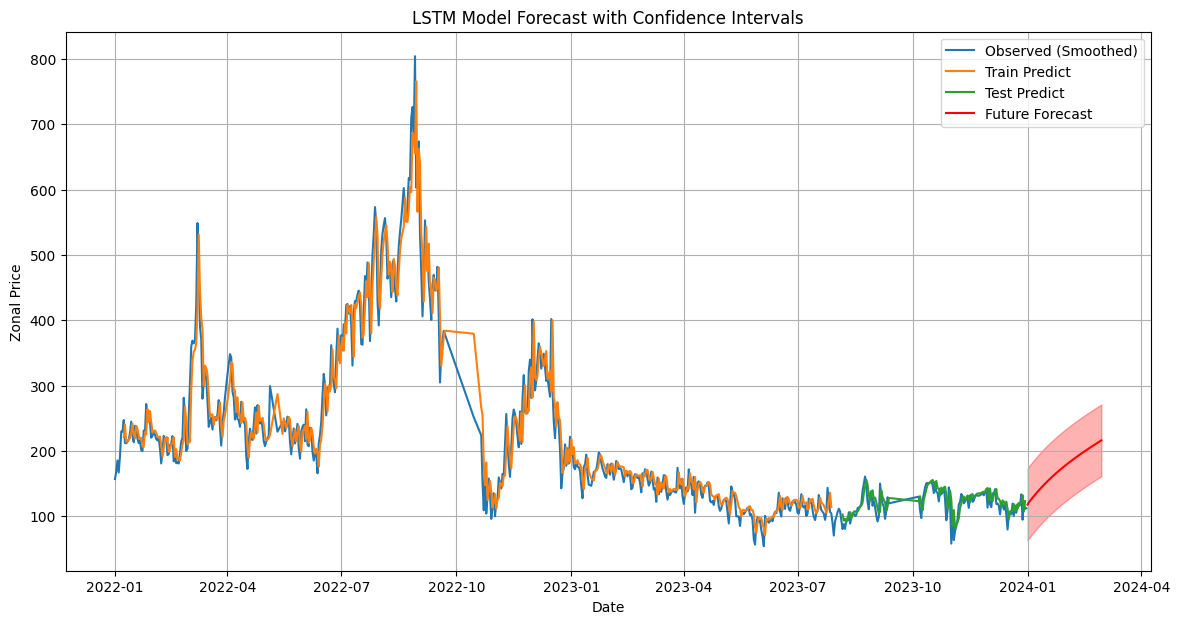

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Load and preprocess data
bid_df['Date'] = pd.to_datetime(bid_df['Date'])
bid_df['Day'] = bid_df['Date'].dt.date

# Aggregate the ZonalPrice by taking the mean for each day
daily_aggregated_df = bid_df.groupby(['Day']).agg({'ZonalPrice': 'mean'}).reset_index()
daily_aggregated_df['Date'] = pd.to_datetime(daily_aggregated_df['Day'])

# Step 2: Smooth the data using Univariate Spline with lambda=0.1
# Apply log transformation to ensure positivity
log_zonal_price = np.log(daily_aggregated_df['ZonalPrice'] + 1)

# Create a spline of the transformed data with smoothing factor
days = np.arange(len(daily_aggregated_df))
spline = UnivariateSpline(days, log_zonal_price, s=0.1)

# Apply the inverse exponential to return to original values
smoothed_price = np.exp(spline(days)) - 1

# Prepare the data for LSTM
data = smoothed_price.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a function to create a dataset with look-back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Define the look-back period
look_back = 7  # one week

# Split data into train and test sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

# Create datasets for training and testing
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build and train the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=30, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calculate root mean squared error
train_score = np.sqrt(np.mean((train_predict[:, 0] - y_train[0]) ** 2))
test_score = np.sqrt(np.mean((test_predict[:, 0] - y_test[0]) ** 2))
print(f'Train Score: {train_score:.2f} RMSE')
print(f'Test Score: {test_score:.2f} RMSE')

# Shift train predictions for plotting
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

# Shift test predictions for plotting
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2) + 1:len(scaled_data) - 1, :] = test_predict

def forecast_future(model, data, look_back, steps):
    future_predictions = []
    current_input = data[-look_back:]
    current_input = np.reshape(current_input, (1, look_back, 1))

    for _ in range(steps):
        future_pred = model.predict(current_input)
        future_predictions.append(future_pred[0, 0])  # Extract the scalar value
        current_input = np.append(current_input[:, 1:, :], [[[future_pred[0,0]]]], axis=1) # Reshape to (1,1,1)

    return np.array(future_predictions)

# Forecast the next 30 days
future_steps = 60
future_predictions = forecast_future(model, scaled_data, look_back, future_steps)

# Invert future predictions
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# Calculate confidence intervals
future_mean = np.mean(future_predictions)
future_std = np.std(future_predictions)
confidence_interval = 1.96 * future_std

# Create future dates for plotting
last_date = daily_aggregated_df['Date'].values[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, inclusive='right')

# Plot baseline, predictions, and future forecasts with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(daily_aggregated_df['Date'], data, label='Observed (Smoothed)')
plt.plot(daily_aggregated_df['Date'], train_predict_plot, label='Train Predict')
plt.plot(daily_aggregated_df['Date'], test_predict_plot, label='Test Predict')
plt.plot(future_dates, future_predictions, label='Future Forecast', color='red')
plt.fill_between(future_dates, (future_predictions - confidence_interval).flatten(), (future_predictions + confidence_interval).flatten(), color='red', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Zonal Price')
plt.title('LSTM Model Forecast with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

## LSTM + callbacks (early stopping and lr reduction

Epoch 1/200
17/17 - 4s - loss: 0.0160 - val_loss: 0.0015 - lr: 0.0100 - 4s/epoch - 213ms/step
Epoch 2/200
17/17 - 0s - loss: 0.0053 - val_loss: 0.0023 - lr: 0.0100 - 121ms/epoch - 7ms/step
Epoch 3/200
17/17 - 0s - loss: 0.0064 - val_loss: 0.0013 - lr: 0.0100 - 118ms/epoch - 7ms/step
Epoch 4/200
17/17 - 0s - loss: 0.0036 - val_loss: 6.6618e-04 - lr: 0.0100 - 116ms/epoch - 7ms/step
Epoch 5/200
17/17 - 0s - loss: 0.0033 - val_loss: 5.4141e-04 - lr: 0.0100 - 122ms/epoch - 7ms/step
Epoch 6/200
17/17 - 0s - loss: 0.0030 - val_loss: 7.4182e-04 - lr: 0.0100 - 116ms/epoch - 7ms/step
Epoch 7/200
17/17 - 0s - loss: 0.0030 - val_loss: 0.0013 - lr: 0.0100 - 119ms/epoch - 7ms/step
Epoch 8/200
17/17 - 0s - loss: 0.0032 - val_loss: 4.9622e-04 - lr: 0.0100 - 122ms/epoch - 7ms/step
Epoch 9/200
17/17 - 0s - loss: 0.0025 - val_loss: 6.8252e-04 - lr: 0.0100 - 108ms/epoch - 6ms/step
Epoch 10/200
17/17 - 0s - loss: 0.0025 - val_loss: 4.1415e-04 - lr: 0.0100 - 120ms/epoch - 7ms/step
Epoch 11/200
17/17 - 0s - 

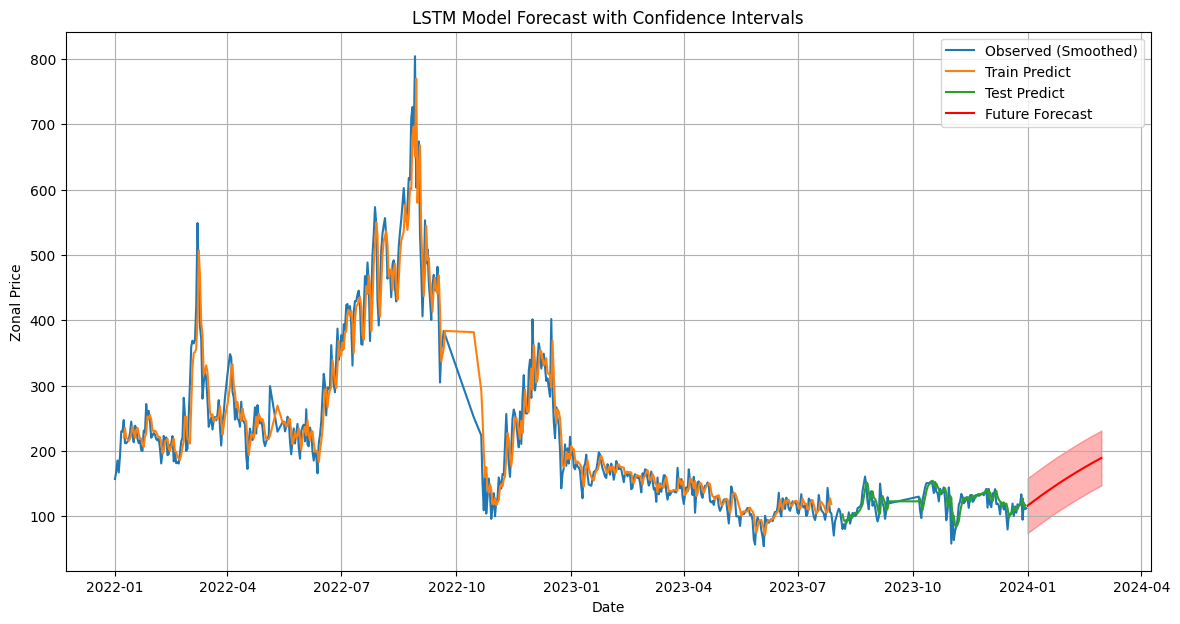

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load and preprocess data
bid_df['Date'] = pd.to_datetime(bid_df['Date'])
bid_df['Day'] = bid_df['Date'].dt.date

# Aggregate the ZonalPrice by taking the mean for each day
daily_aggregated_df = bid_df.groupby(['Day']).agg({'ZonalPrice': 'mean'}).reset_index()
daily_aggregated_df['Date'] = pd.to_datetime(daily_aggregated_df['Day'])

# Step 2: Smooth the data using Univariate Spline with lambda=0.1
# Apply log transformation to ensure positivity
log_zonal_price = np.log(daily_aggregated_df['ZonalPrice'] + 1)

# Create a spline of the transformed data with smoothing factor
days = np.arange(len(daily_aggregated_df))
spline = UnivariateSpline(days, log_zonal_price, s=0.1)

# Apply the inverse exponential to return to original values
smoothed_price = np.exp(spline(days)) - 1

# Prepare the data for LSTM
data = smoothed_price.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a function to create a dataset with look-back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Define the look-back period
look_back = 7  # one week

# Split data into train and test sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

# Create datasets for training and testing
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build and train the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, min_lr=0.0001)

# Train the model with early stopping and learning rate reduction
batch_size = 32
model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=2, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calculate root mean squared error
train_score = np.sqrt(np.mean((train_predict[:, 0] - y_train[0]) ** 2))
test_score = np.sqrt(np.mean((test_predict[:, 0] - y_test[0]) ** 2))
print(f'Train Score: {train_score:.2f} RMSE')
print(f'Test Score: {test_score:.2f} RMSE')

# Shift train predictions for plotting
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

# Shift test predictions for plotting
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2) + 1:len(scaled_data) - 1, :] = test_predict

# Function to forecast future values
def forecast_future(model, data, look_back, steps):
    future_predictions = []
    current_input = data[-look_back:]
    current_input = np.reshape(current_input, (1, look_back, 1))

    for _ in range(steps):
        future_pred = model.predict(current_input)
        future_predictions.append(future_pred[0, 0])  # Extract the scalar value
        current_input = np.append(current_input[:, 1:, :], [[[future_pred[0, 0]]]], axis=1)  # Reshape to (1,1,1)

    return np.array(future_predictions)

# Forecast the next 60 days
future_steps = 60
future_predictions = forecast_future(model, scaled_data, look_back, future_steps)

# Invert future predictions
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# Calculate confidence intervals
future_mean = np.mean(future_predictions)
future_std = np.std(future_predictions)
confidence_interval = 1.96 * future_std

# Create future dates for plotting
last_date = daily_aggregated_df['Date'].values[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, inclusive='right')

# Plot baseline, predictions, and future forecasts with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(daily_aggregated_df['Date'], data, label='Observed (Smoothed)')
plt.plot(daily_aggregated_df['Date'], train_predict_plot, label='Train Predict')
plt.plot(daily_aggregated_df['Date'], test_predict_plot, label='Test Predict')
plt.plot(future_dates, future_predictions, label='Future Forecast', color='red')
plt.fill_between(future_dates, (future_predictions - confidence_interval).flatten(), (future_predictions + confidence_interval).flatten(), color='red', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Zonal Price')
plt.title('LSTM Model Forecast with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

## adjusting parameters

Epoch 1/60
17/17 - 5s - loss: 0.0278 - val_loss: 0.0135 - lr: 0.0010 - 5s/epoch - 282ms/step
Epoch 2/60
17/17 - 0s - loss: 0.0076 - val_loss: 0.0027 - lr: 0.0010 - 117ms/epoch - 7ms/step
Epoch 3/60
17/17 - 0s - loss: 0.0044 - val_loss: 5.8686e-04 - lr: 0.0010 - 111ms/epoch - 7ms/step
Epoch 4/60
17/17 - 0s - loss: 0.0043 - val_loss: 5.5979e-04 - lr: 0.0010 - 116ms/epoch - 7ms/step
Epoch 5/60
17/17 - 0s - loss: 0.0041 - val_loss: 9.4562e-04 - lr: 0.0010 - 112ms/epoch - 7ms/step
Epoch 6/60
17/17 - 0s - loss: 0.0043 - val_loss: 9.2334e-04 - lr: 0.0010 - 106ms/epoch - 6ms/step
Epoch 7/60
17/17 - 0s - loss: 0.0042 - val_loss: 6.3342e-04 - lr: 0.0010 - 107ms/epoch - 6ms/step
Epoch 8/60
17/17 - 0s - loss: 0.0039 - val_loss: 5.6266e-04 - lr: 0.0010 - 126ms/epoch - 7ms/step
Epoch 9/60
17/17 - 0s - loss: 0.0065 - val_loss: 0.0037 - lr: 0.0010 - 118ms/epoch - 7ms/step
Epoch 10/60
17/17 - 0s - loss: 0.0044 - val_loss: 7.5377e-04 - lr: 0.0010 - 126ms/epoch - 7ms/step
Epoch 11/60
17/17 - 0s - loss: 0

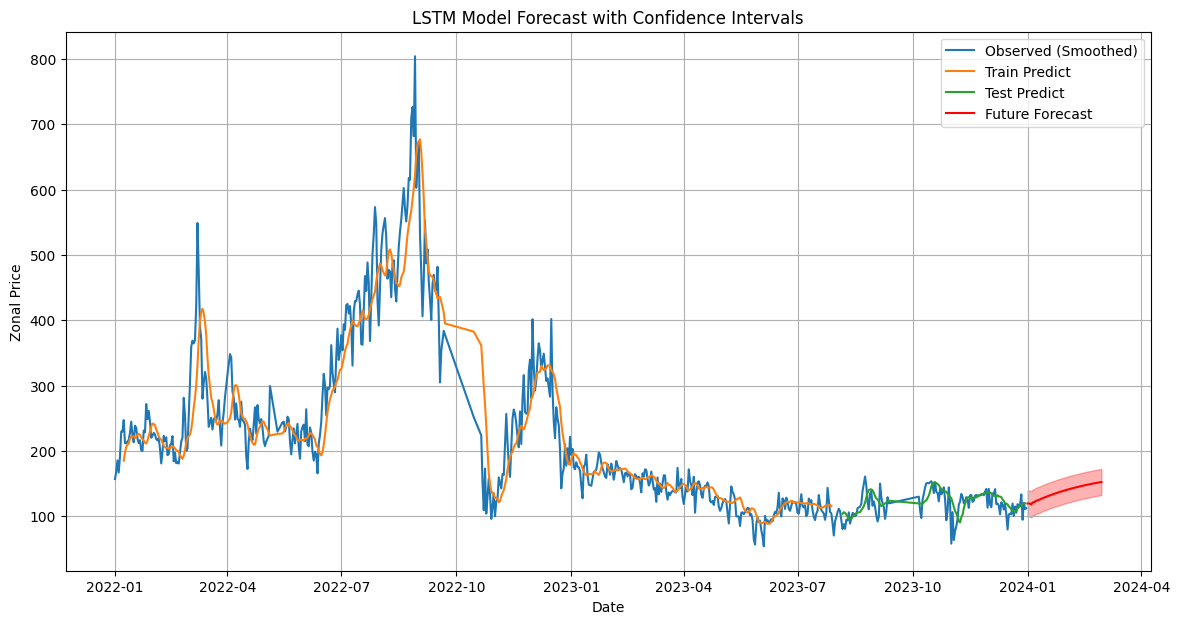

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load and preprocess data
bid_df['Date'] = pd.to_datetime(bid_df['Date'])
bid_df['Day'] = bid_df['Date'].dt.date

# Aggregate the ZonalPrice by taking the mean for each day
daily_aggregated_df = bid_df.groupby(['Day']).agg({'ZonalPrice': 'mean'}).reset_index()
daily_aggregated_df['Date'] = pd.to_datetime(daily_aggregated_df['Day'])

# Step 2: Smooth the data using Univariate Spline with lambda=0.1
# Apply log transformation to ensure positivity
log_zonal_price = np.log(daily_aggregated_df['ZonalPrice'] + 1)

# Create a spline of the transformed data with smoothing factor
days = np.arange(len(daily_aggregated_df))
spline = UnivariateSpline(days, log_zonal_price, s=0.1)

# Apply the inverse exponential to return to original values
smoothed_price = np.exp(spline(days)) - 1

# Prepare the data for LSTM
data = smoothed_price.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a function to create a dataset with look-back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Define the look-back period
look_back = 7  # one week

# Split data into train and test sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

# Create datasets for training and testing
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build and train the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model with early stopping and learning rate reduction
batch_size = 32
model.fit(X_train, y_train, epochs=60, batch_size=batch_size, verbose=2, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calculate root mean squared error
train_score = np.sqrt(np.mean((train_predict[:, 0] - y_train[0]) ** 2))
test_score = np.sqrt(np.mean((test_predict[:, 0] - y_test[0]) ** 2))
print(f'Train Score: {train_score:.2f} RMSE')
print(f'Test Score: {test_score:.2f} RMSE')

# Shift train predictions for plotting
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

# Shift test predictions for plotting
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2) + 1:len(scaled_data) - 1, :] = test_predict

# Function to forecast future values
def forecast_future(model, data, look_back, steps):
    future_predictions = []
    current_input = data[-look_back:]
    current_input = np.reshape(current_input, (1, look_back, 1))

    for _ in range(steps):
        future_pred = model.predict(current_input)
        future_predictions.append(future_pred[0, 0])  # Extract the scalar value
        current_input = np.append(current_input[:, 1:, :], [[[future_pred[0, 0]]]], axis=1)  # Reshape to (1,1,1)

    return np.array(future_predictions)

# Forecast the next 60 days
future_steps = 60
future_predictions = forecast_future(model, scaled_data, look_back, future_steps)

# Invert future predictions
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# Calculate confidence intervals
future_mean = np.mean(future_predictions)
future_std = np.std(future_predictions)
confidence_interval = 1.96 * future_std

# Create future dates for plotting
last_date = daily_aggregated_df['Date'].values[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, inclusive='right')

# Plot baseline, predictions, and future forecasts with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(daily_aggregated_df['Date'], data, label='Observed (Smoothed)')
plt.plot(daily_aggregated_df['Date'], train_predict_plot, label='Train Predict')
plt.plot(daily_aggregated_df['Date'], test_predict_plot, label='Test Predict')
plt.plot(future_dates, future_predictions, label='Future Forecast', color='red')
plt.fill_between(future_dates, (future_predictions - confidence_interval).flatten(), (future_predictions + confidence_interval).flatten(), color='red', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Zonal Price')
plt.title('LSTM Model Forecast with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()